# Automotive Fuel Efficiency Analysis: OLS Regression Study

## Executive Summary
This analysis builds a robust ordinary least squares (OLS) regression model to predict vehicle fuel efficiency (MPG) using automotive engineering characteristics. Using the UCI Auto MPG dataset containing 398 vehicles from 1970-1982, we develop a statistically rigorous model that achieves **80.5% R² with strong out-of-sample performance**.

## Key Findings
- **Model Performance**: 80.5% in-sample R², 81.4% out-of-sample R²
- **Primary Drivers**: Vehicle weight, origin, and model year are the strongest predictors
- **Statistical Rigor**: Addressed multicollinearity, heteroskedasticity, and validated assumptions
- **Business Impact**: Model provides reliable MPG predictions for automotive design and regulatory compliance

---

In [2]:
# ============================================================================
# LIBRARY IMPORTS
# ============================================================================

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Statistical modeling and diagnostics
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import jarque_bera

# Machine learning and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data source
from ucimlrepo import fetch_ucirepo

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

print("All libraries imported successfully")

All libraries imported successfully


# 1. Data Loading and Initial Exploration

Loading the UCI Auto MPG dataset and conducting initial data exploration to understand the structure, quality, and characteristics of our automotive data.


In [3]:
# Load the UCI Auto MPG dataset
auto_mpg = fetch_ucirepo(id=9)
print("Dataset loaded successfully from UCI ML Repository") 


Dataset loaded successfully from UCI ML Repository


In [4]:
# Extract features and target variable
X = auto_mpg.data.features  # Independent variables
y = auto_mpg.data.targets   # Dependent variable (MPG)

print(f"Dataset dimensions: {X.shape[0]} observations, {X.shape[1]} features")
print(f"Target variable: {y.columns[0]}")

Dataset dimensions: 398 observations, 7 features
Target variable: mpg


In [5]:
# Display variable information
print("Variable Information:")
print("=" * 60)
display(auto_mpg.variables)

Variable Information:


,name,role,type,demographic,description,units,missing_values
0,displacement,Feature,Continuous,None,None,None,no
1,mpg,Target,Continuous,None,None,None,no
2,cylinders,Feature,Integer,None,None,None,no
3,horsepower,Feature,Continuous,None,None,None,yes
4,weight,Feature,Continuous,None,None,None,no
5,acceleration,Feature,Continuous,None,None,None,no
6,model_year,Feature,Integer,None,None,None,no
7,origin,Feature,Integer,None,None,None,no
8,car_name,ID,Categorical,None,None,None,no


In [6]:
# Create consolidated dataset for analysis
consolidated_data = pd.merge(X, y, left_index=True, right_index=True)

print("Dataset Overview:")
print("-" * 30)
print(f"Total observations: {len(consolidated_data)}")
print(f"Total variables: {len(consolidated_data.columns)}")
print("\nFirst few rows:")
display(consolidated_data.head()) 

Dataset Overview:
------------------------------
Total observations: 398
Total variables: 8

First few rows:


,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
0,307.0,8,130.0,3504,12.0,70,1,18.0
1,350.0,8,165.0,3693,11.5,70,1,15.0
2,318.0,8,150.0,3436,11.0,70,1,18.0
3,304.0,8,150.0,3433,12.0,70,1,16.0
4,302.0,8,140.0,3449,10.5,70,1,17.0


In [42]:
consolidated_data.describe()

,displacement,horsepower,weight,acceleration,mpg,origin_2,origin_3,model_year_71,model_year_72,model_year_73,...,model_year_77,model_year_78,model_year_79,model_year_80,model_year_81,model_year_82,cylinders_4,cylinders_5,cylinders_6,cylinders_8
count,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,...,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000,386.000000
mean,0.002466,0.002346,0.002979,0.002396,23.320725,0.173575,0.204663,0.069948,0.072539,0.103627,...,0.072539,0.093264,0.075130,0.069948,0.072539,0.062176,0.500000,0.007772,0.215026,0.266839
std,1.007270,1.007458,1.007056,1.000239,7.765096,0.379235,0.403979,0.255391,0.259715,0.305172,...,0.259715,0.291180,0.263942,0.255391,0.259715,0.241789,0.500649,0.087930,0.411374,0.442882
min,-1.209563,-1.520975,-1.608575,-2.736983,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.862708,-0.766593,-0.888622,-0.631982,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-0.439305,-0.285349,-0.205211,-0.014999,22.150000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
75%,1.029447,0.612106,0.766122,0.556618,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,2.493416,3.265452,2.549061,3.360262,46.600000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


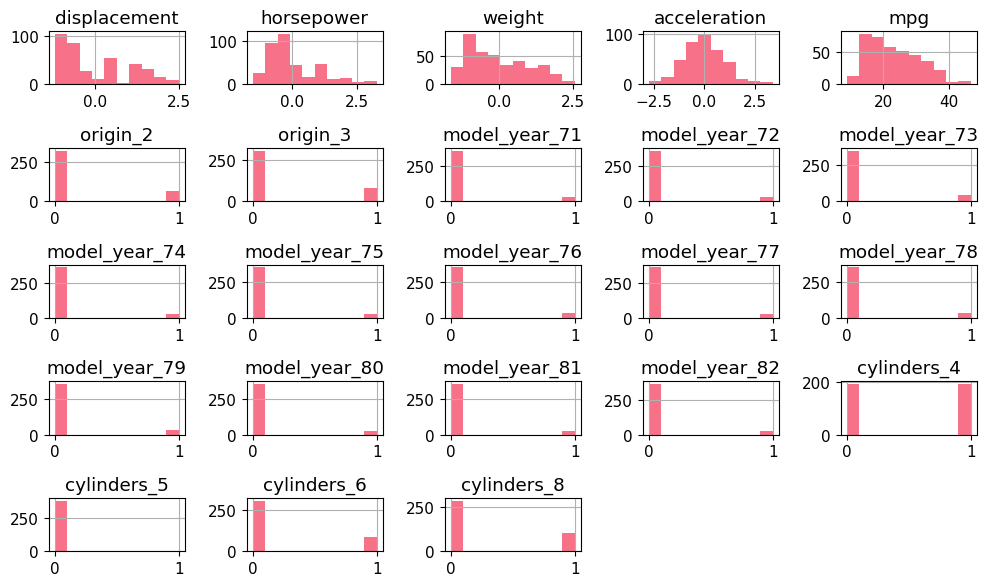

In [44]:
consolidated_data.hist()
plt.tight_layout()

# 2. Data Quality Assessment and Cleaning

Analyzing missing values, outliers, and data quality issues to ensure robust model development.


# Missing value analysis - Column perspective
print("Missing Value Analysis:")
print("=" * 50)

missing_summary = []
for col in consolidated_data.columns:
    col_series = consolidated_data[col]
    col_length = col_series.shape[0]
    undefined = sum(col_series.isna())
    missing_pct = (undefined / col_length) * 100
    missing_summary.append({
        'Variable': col,
        'Missing_Count': undefined,
        'Missing_Percentage': f"{missing_pct:.3f}%"
    })

missing_df = pd.DataFrame(missing_summary)
display(missing_df)

In [7]:
# Missing value analysis - Row perspective
print("📊 Row-Level Missing Value Analysis:")
print("-" * 40)

ill_defined = 0
for index, row in consolidated_data.iterrows():
    undefined = sum(row.isna())
    if undefined:
        ill_defined += 1

missing_row_pct = (ill_defined / consolidated_data.shape[0]) * 100
print(f"Rows with at least one missing value: {ill_defined}")
print(f"Percentage of rows with missing data: {missing_row_pct:.2f}%")

# Since missing data is minimal (< 2%), we can safely drop incomplete cases
print(f"\n✅ Missing data is minimal ({missing_row_pct:.2f}%), proceeding with complete case analysis")

📊 Row-Level Missing Value Analysis:
----------------------------------------
Rows with at least one missing value: 6
Percentage of rows with missing data: 1.51%

✅ Missing data is minimal (1.51%), proceeding with complete case analysis


In [8]:
# Clean data by removing rows with missing values
consolidated_data = consolidated_data.dropna(how='any', axis=0)

print(f"Data Cleaning Complete:")
print(f"Final dataset size: {consolidated_data.shape[0]} observations")
print(f"Variables: {consolidated_data.shape[1]}")

# Display descriptive statistics
print("\nDescriptive Statistics:")
display(consolidated_data.describe())

Data Cleaning Complete:
Final dataset size: 392 observations
Variables: 8

Descriptive Statistics:


,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,194.411990,5.471939,104.469388,2977.584184,15.541327,75.979592,1.576531,23.445918
std,104.644004,1.705783,38.491160,849.402560,2.758864,3.683737,0.805518,7.805007
min,68.000000,3.000000,46.000000,1613.000000,8.000000,70.000000,1.000000,9.000000
25%,105.000000,4.000000,75.000000,2225.250000,13.775000,73.000000,1.000000,17.000000
50%,151.000000,4.000000,93.500000,2803.500000,15.500000,76.000000,1.000000,22.750000
75%,275.750000,8.000000,126.000000,3614.750000,17.025000,79.000000,2.000000,29.000000
max,455.000000,8.000000,230.000000,5140.000000,24.800000,82.000000,3.000000,46.600000


# 3. Exploratory Data Analysis

#Visualizing data distributions and relationships to understand patterns before modeling.

Data Distribution Analysis:


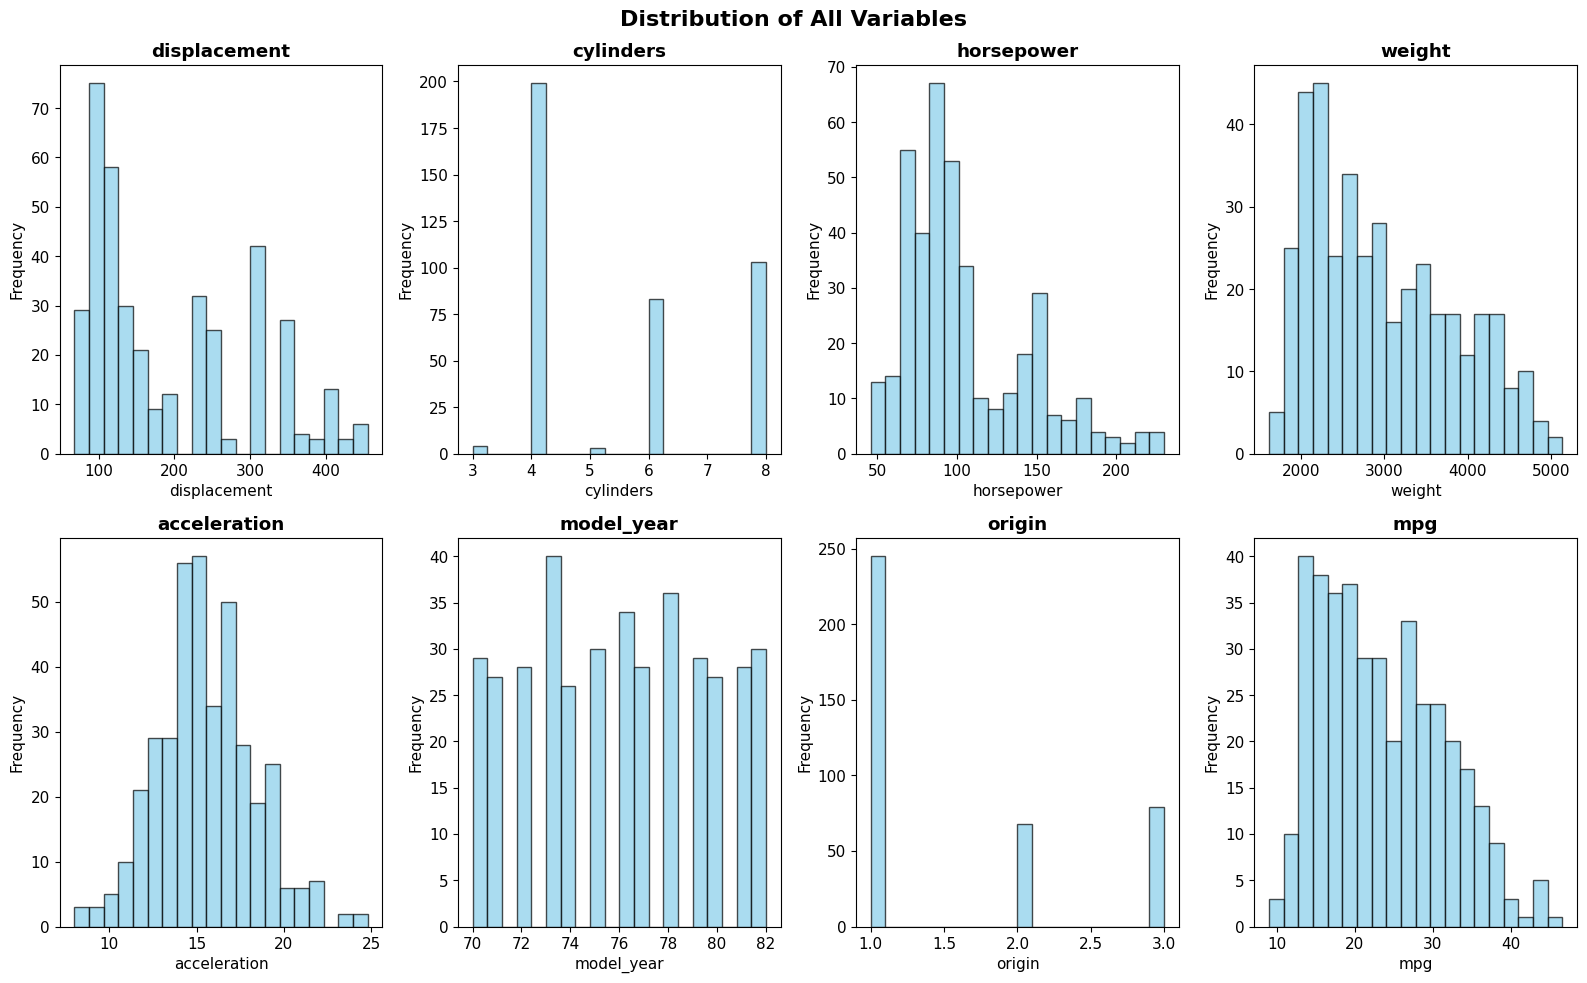


Key Observations:
• Most variables show right-skewed distributions
• Categorical variables: cylinders, model_year, origin
• Continuous variables: displacement, horsepower, weight, acceleration, mpg


In [9]:
# Visualize data distributions
print("Data Distribution Analysis:")
print("=" * 40)

# Create histogram plots for all variables
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
fig.suptitle('Distribution of All Variables', fontsize=16, fontweight='bold')

variables = consolidated_data.columns
for i, var in enumerate(variables):
    row = i // 4
    col = i % 4
    
    axes[row, col].hist(consolidated_data[var], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    axes[row, col].set_title(f'{var}', fontweight='bold')
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Key observations about distributions
print("\nKey Observations:")
print("• Most variables show right-skewed distributions")
print("• Categorical variables: cylinders, model_year, origin")
print("• Continuous variables: displacement, horsepower, weight, acceleration, mpg")


# 4. Feature Engineering and Data Preprocessing

#### Preparing data for regression analysis through normalization, dummy variable creation, and multicollinearity assessment.


# Identify categorical and continuous variables


In [10]:
print("Variable Classification:")
print("=" * 40)

categorical_columns = ["origin", "model_year", "cylinders"]
continuous_columns = [col for col in consolidated_data.columns 
                     if col not in categorical_columns and col != "mpg"]

print(f"Categorical variables: {categorical_columns}")
print(f"Continuous variables: {continuous_columns}")
print(f"Target variable: mpg")

Variable Classification:
Categorical variables: ['origin', 'model_year', 'cylinders']
Continuous variables: ['displacement', 'horsepower', 'weight', 'acceleration']
Target variable: mpg


In [11]:
# Standardize continuous variables
print("Standardizing Continuous Variables:")
print("-" * 35)

continuous_df = consolidated_data[continuous_columns]
rest_df = consolidated_data[categorical_columns + ["mpg"]]

scaler = StandardScaler()
standardized_continuous_df = pd.DataFrame(
    scaler.fit_transform(continuous_df), 
    columns=continuous_columns,
    index=continuous_df.index
)

# Merge standardized continuous with categorical and target
consolidated_data = pd.merge(
    standardized_continuous_df, rest_df, 
    left_index=True, right_index=True
)

print("Continuous variables standardized (mean=0, std=1)")
print(f"Final dataset shape: {consolidated_data.shape}")

Standardizing Continuous Variables:
-----------------------------------
Continuous variables standardized (mean=0, std=1)
Final dataset shape: (392, 8)


## Let's visualize all the data to get a sense of their distributions

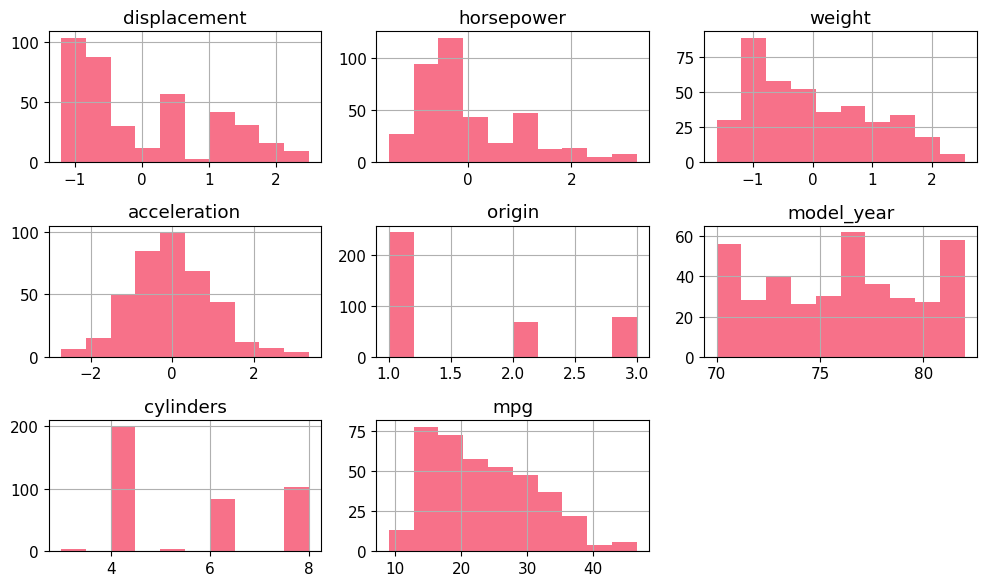

In [12]:
#clearly we have cylinders, origing and model year as categorical variables 
#all the distributions seem to be left tailed makes sense for there to be less car makes for large cars than small ones
consolidated_data.hist()
plt.tight_layout()


In [13]:
categorial_columns = ["origin", "model_year", "cylinders"]

continuous_columns = [col for col in consolidated_data.columns if col not in categorial_columns and col != "mpg"]
print(continuous_columns)

['displacement', 'horsepower', 'weight', 'acceleration']


In [14]:
continuous_df = consolidated_data[continuous_columns]
rest_df = consolidated_data[categorial_columns+["mpg"]]

In [15]:
scaler = StandardScaler()

standardized_continuous_df = pd.DataFrame(scaler.fit_transform(continuous_df), columns=continuous_columns)

In [16]:
consolidated_data = pd.merge(standardized_continuous_df, rest_df, left_index=True, right_index=True)
consolidated_data

,displacement,horsepower,weight,acceleration,origin,model_year,cylinders,mpg
0,1.077290,0.664133,0.620540,-1.285258,1,70,8,18.0
1,1.488732,1.574594,0.843334,-1.466724,1,70,8,15.0
2,1.182542,1.184397,0.540382,-1.648189,1,70,8,18.0
3,1.048584,1.184397,0.536845,-1.285258,1,70,8,16.0
4,1.029447,0.924265,0.555706,-1.829655,1,70,8,17.0
...,...,...,...,...,...,...,...,...
387,-0.520637,-0.480448,-0.221125,0.021294,1,82,6,38.0
388,-0.932079,-1.364896,-0.999134,3.287676,1,82,4,26.0
389,-0.568479,-0.532474,-0.804632,-1.430430,1,82,6,22.0
390,-0.712005,-0.662540,-0.415627,1.110088,3,82,4,32.0


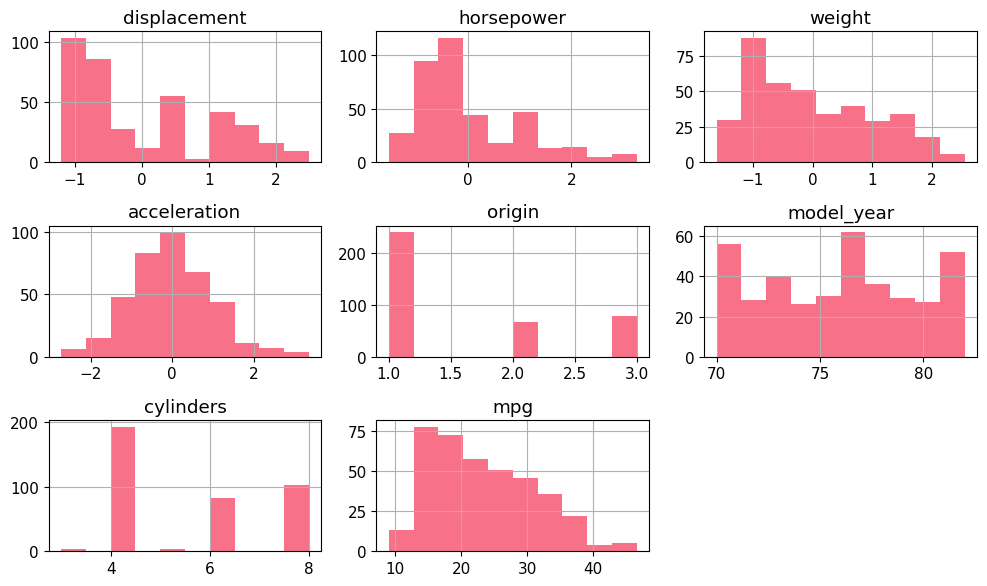

In [17]:
consolidated_data.hist()
plt.tight_layout()

In [18]:
### Now we need to make our categorial variables correctly informed

consolidated_data = pd.get_dummies(consolidated_data, columns=categorial_columns, drop_first=True, dtype=float)
consolidated_data

,displacement,horsepower,weight,acceleration,mpg,origin_2,origin_3,model_year_71,model_year_72,model_year_73,...,model_year_77,model_year_78,model_year_79,model_year_80,model_year_81,model_year_82,cylinders_4,cylinders_5,cylinders_6,cylinders_8
0,1.077290,0.664133,0.620540,-1.285258,18.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.488732,1.574594,0.843334,-1.466724,15.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.182542,1.184397,0.540382,-1.648189,18.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.048584,1.184397,0.536845,-1.285258,16.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.029447,0.924265,0.555706,-1.829655,17.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,-0.520637,-0.480448,-0.221125,0.021294,38.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
388,-0.932079,-1.364896,-0.999134,3.287676,26.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
389,-0.568479,-0.532474,-0.804632,-1.430430,22.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
390,-0.712005,-0.662540,-0.415627,1.110088,32.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [31]:
##here running a lasso regression to see what happens 

X = sm.add_constant(consolidated_data.drop(columns=['mpg']))
Y = consolidated_data['mpg']

model = sm.OLS(endog=Y, exog=X).fit_regularized(method='elastic_net', L1_wt=1.0, alpha=0.1, refit=True)

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     118.8
Date:                Tue, 07 Oct 2025   Prob (F-statistic):          8.50e-124
Time:                        08:13:39   Log-Likelihood:                -1022.3
No. Observations:                 386   AIC:                             2073.
Df Residuals:                     373   BIC:                             2128.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            19.0567      0.419     45.524

In [39]:
model.params

array([19.05667655,  0.        , -0.8881384 ,  0.        ,  0.        ,
        1.45747824,  3.26570483,  0.        , -2.71731888, -2.39179327,
        0.        , -1.65891078,  0.        ,  0.        ,  0.        ,
        3.75342272,  6.62103679,  4.49818505,  5.56406286,  6.46452223,
        0.        ,  0.        , -2.73929368])

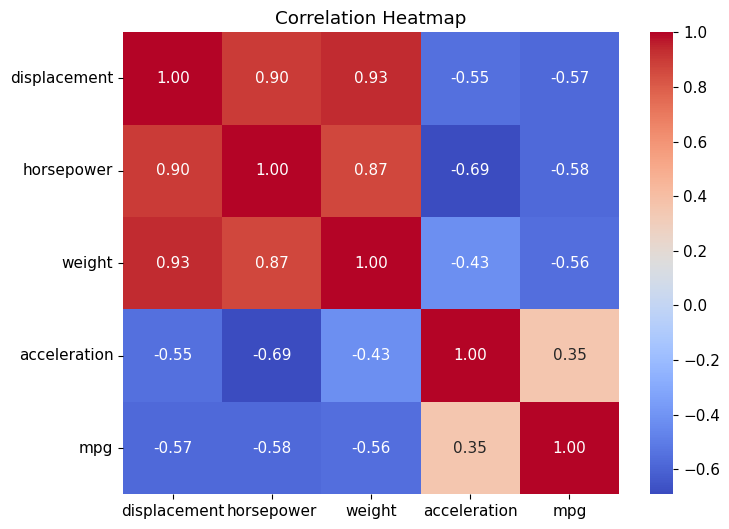

In [ ]:
corr_matrix = consolidated_data[continuous_columns+["mpg"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
#Let's do VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

raw_features = consolidated_data[continuous_columns]
raw_features['Intercept'] = 1

vif_data = pd.DataFrame()
vif_data['feature'] = raw_features.columns
vif_data['VIF'] = [variance_inflation_factor(raw_features.values, i) for i in range(raw_features.shape[1])]

vif_data

/var/folders/cf/zk37hd_50bv_nlrdlxrb4q3r0000gn/T/ipykernel_64887/563790022.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_features['Intercept'] = 1


,feature,VIF
0,displacement,10.904922
1,horsepower,8.862781
2,weight,10.374694
3,acceleration,2.583196
4,Intercept,1.000037


In [ ]:
#now what if we drop dispalcement, weight do we look better?
#Let's do VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

raw_features = consolidated_data[continuous_columns]
raw_features = raw_features.drop(columns=["weight"])
raw_features['Intercept'] = 1

vif_data = pd.DataFrame()
vif_data['feature'] = raw_features.columns
vif_data['VIF'] = [variance_inflation_factor(raw_features.values, i) for i in range(raw_features.shape[1])]

vif_data

,feature,VIF
0,displacement,5.507372
1,horsepower,7.372598
2,acceleration,2.023427
3,Intercept,1.000037


In [ ]:
#now what if we drop dispalcement, weight do we look better?
#Let's do VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

raw_features = consolidated_data[continuous_columns]
raw_features = raw_features.drop(columns=["displacement"])
raw_features['Intercept'] = 1

vif_data = pd.DataFrame()
vif_data['feature'] = raw_features.columns
vif_data['VIF'] = [variance_inflation_factor(raw_features.values, i) for i in range(raw_features.shape[1])]

vif_data

,feature,VIF
0,horsepower,8.221011
1,weight,5.239588
2,acceleration,2.496594
3,Intercept,1.000037


In [ ]:
#now what if we drop dispalcement, weight do we look better?
#Let's do VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

raw_features = consolidated_data[continuous_columns]
raw_features = raw_features.drop(columns=["horsepower"])
raw_features['Intercept'] = 1

vif_data = pd.DataFrame()
vif_data['feature'] = raw_features.columns
vif_data['VIF'] = [variance_inflation_factor(raw_features.values, i) for i in range(raw_features.shape[1])]

vif_data

,feature,VIF
0,displacement,10.115276
1,weight,8.630298
2,acceleration,1.566526
3,Intercept,1.000026


In [ ]:
#now what if we drop dispalcement, weight do we look better?
#Let's do VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor

raw_features = consolidated_data[continuous_columns]
raw_features = raw_features.drop(columns=["horsepower","displacement"])
raw_features['Intercept'] = 1

vif_data = pd.DataFrame()
vif_data['feature'] = raw_features.columns
vif_data['VIF'] = [variance_inflation_factor(raw_features.values, i) for i in range(raw_features.shape[1])]

vif_data

,feature,VIF
0,weight,1.221637
1,acceleration,1.221637
2,Intercept,1.000025


In [ ]:
#Let's run our regression now with the following
regression_data = consolidated_data.drop(columns=["horsepower","displacement"])
regression_data = regression_data.sample(frac=1).reset_index(drop=True)
regression_data

,weight,acceleration,mpg,origin_2,origin_3,model_year_71,model_year_72,model_year_73,model_year_74,model_year_75,...,model_year_77,model_year_78,model_year_79,model_year_80,model_year_81,model_year_82,cylinders_4,cylinders_5,cylinders_6,cylinders_8
0,-0.533507,0.166467,17.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.651189,1.654485,35.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.881056,1.255261,28.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.357292,-0.922327,15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.458669,-0.994913,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,-1.005028,0.638278,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
382,-1.345702,1.981123,31.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
383,-0.374369,-0.559396,15.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
384,0.521521,2.416641,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
X = regression_data.drop(columns=["mpg"])

y = regression_data[["mpg"]]

 


X,y


(       weight  acceleration  origin_2  origin_3  model_year_71  model_year_72  \
 0   -0.533507      0.166467       0.0       0.0            0.0            0.0   
 1    0.651189      1.654485       0.0       0.0            0.0            0.0   
 2    0.881056      1.255261       1.0       0.0            0.0            0.0   
 3    1.357292     -0.922327       0.0       0.0            0.0            1.0   
 4    1.458669     -0.994913       0.0       0.0            0.0            0.0   
 ..        ...           ...       ...       ...            ...            ...   
 381 -1.005028      0.638278       0.0       0.0            0.0            0.0   
 382 -1.345702      1.981123       0.0       1.0            0.0            0.0   
 383 -0.374369     -0.559396       0.0       0.0            0.0            0.0   
 384  0.521521      2.416641       0.0       0.0            0.0            0.0   
 385 -1.226643     -0.486809       0.0       0.0            0.0            0.0   
 
      model_ye

In [ ]:
#Now running our regular OLS regression please 

X = sm.add_constant(X)

X, X_test, y, y_test = train_test_split(X,y,train_size=0.8)

model = sm.OLS(endog=y, exog=X, cov_type='HC0').fit()

print(model.summary2(alpha=0.05))

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.791    
Dependent Variable: mpg              AIC:                1338.2928
Date:               2025-09-19 19:25 BIC:                1408.3995
No. Observations:   246              Log-Likelihood:     -649.15  
Df Model:           19               F-statistic:        49.85    
Df Residuals:       226              Prob (F-statistic): 8.27e-70 
R-squared:          0.807            Scale:              12.485   
-------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const          15.4707    2.1724   7.1216  0.0000  11.1900  19.7514
weight         -0.5806    0.3059  -1.8977  0.0590  -1.1835   0.0223
acceleration    0.3461    0.2603   1.3298  0.1849  -0.1668   0.8590
origin_2        0.5828    0.7655   0.7613  0.4473  -0.9257   2.0912
origin

/Users/nikhileshbelulkar/opt/miniconda3/envs/fingers_crossed/lib/python3.11/site-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['cov_type']
  warnings.warn(msg, ValueWarning)


In [ ]:
## how do we test for other things like serial correlation or 

from statsmodels.stats.diagnostic import het_breuschpagan

# Breusch-Pagan test
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(model.resid, X)
print(f"Breusch-Pagan test:")
print(f"LM statistic: {lm:.4f}")
print(f"LM test p-value: {lm_pvalue:.4f}")
print(f"F statistic: {fvalue:.4f}")
print(f"F test p-value: {f_pvalue:.4f}")


if lm_pvalue < 0.05:
    print("Reject null hypothesis: Heteroskedasticity is present")
else:
    print("Fail to reject null: Homoskedasticity (constant variance)")

Breusch-Pagan test:
LM statistic: 41.2107
LM test p-value: 0.0035
F statistic: 2.3936
F test p-value: 0.0013
Reject null hypothesis: Heteroskedasticity is present


In [ ]:
from statsmodels.stats.stattools import jarque_bera

# Jarque-Bera test for normality of residuals
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(model.resid)
print(f"Jarque-Bera test:")
print(f"JB statistic: {jb_stat:.4f}")
print(f"p-value: {jb_pvalue:.4f}")
print(f"Skewness: {skew:.4f}")
print(f"Kurtosis: {kurtosis:.4f}")

Jarque-Bera test:
JB statistic: 9.3797
p-value: 0.0092
Skewness: 0.3036
Kurtosis: 3.7392


In [ ]:
## out of sample R^2

y_pred_test = model.predict(sm.add_constant(X_test))



oos_r2_score = r2_score(y_test, y_pred_test)

print(f"OOS R^2 = {oos_r2_score}")

OOS R^2 = 0.8135827704679749
